#Project 1: DCT Compression of an Intraframe

#Introduction

In Project 1, we are going to implement an intraframe compression
process via DCT transformation and quantization. Specifically, this
process is realized by:
1. Segmenting an intraframe image into patches
2. Converting each image patch into DCT coefficients
3. Quantizing the DCT coefficients.
You also need to reconstruct the compressed frame via a reverse
process: inverse DCT transform of each compressed patch by using
quantized DCT coefficients and regroup them back to a frame.

Please follow these steps to prepare for the tasks:
1. Download the given video file in the course files and add it to the project files.
2. Import the libraries below.


In [1]:
#LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pylab

#Tasks

Task 0. A piece of cake

1. Extract frame number 80 from the video file
2. Convert the frame from RGB to YUV by using your function
“frameRGB2YUV”.

In [47]:
#VIDEO

# Here are the additional functions you will need to call in this lab
# y = Diffimage(x1, x2)
# y = Reconsimage(x1, x2)

# Put your code from the VIDEO block from previous assignments here.
# Set up to read video. Set string to name of your clip.
cap = cv2.VideoCapture('test_video-1.mp4')

if cap.isOpened() == False:
    print("That's probably not the name of your clip")

# Some information about the video file
cap_e = int(cap.get(0)) # Elapsed video time in milliseconds
cap_w = int(cap.get(3)) # Frame width
cap_h = int(cap.get(4)) # Frame height
cap_r = int(cap.get(5)) # Frame rate
cap_l = int(cap.get(7)) # Length in number of frames
# Under VideoCapture::get is a list of attributes
# https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-open

# Set up to write video. You can set title and resolution.
result = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'MP4V'), cap_r, (cap_w, cap_h))

#prepping to extract a random frame
count = 0

while True:
    # ret is true if video.read() returns a frame
    # frame is the frame returned
    ret, frame = cap.read()

    if ret is True:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
      #extracts a random frame
      if count == 79:
        cv2.imwrite("lab1video.jpg", frame)
        YUVframe80 = np.rint(frameRGB2YUV(frame))
        frame80 = YUVframe80[:,:,0].astype(int)
        test = frame80.copy()
        #plt.imshow(frame80, cmap = "gray")
        #plt.show()
    
      count += 1

        # 'q' to cancel
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    else:
        break

# Close down
cap.release()
result.release()
cv2.destroyAllWindows()




In [2]:
#RGB2YUV

# Put your code from the RGB2YUV block previous assignments here.
def frameRGB2YUV(RGBframe):
  # Transform RGB to YUV
  imagearray = np.array(RGBframe)
  imagearray = imagearray.astype("uint8")
  transform_matrix = np.array([[0.2126, 0.7152, 0.0722], [-0.09991, -0.33609, 0.436], [0.615, -0.55861, -0.05639]])
  YUVframe = np.matmul(imagearray, transform_matrix)
  y, u, v = cv2.split(YUVframe)

  # Downsamples/Upsamples
  dim_down = (int(u.shape[1] / 2), int(u.shape[0] / 2))
  dim_up = (int(u.shape[1]), int(u.shape[0]))
  
  u_comp = cv2.resize(cv2.resize(u, dim_down), dim_up)
  v_comp = cv2.resize(cv2.resize(v, dim_down), dim_up)

  YUVframe = cv2.merge((y, u_comp, v_comp))
  YUVframe = np.clip(YUVframe, 0, 255)
  YUVframe = YUVframe.astype("uint8")
  
  return YUVframe

Task 1. Cut

Segment the frame into patches with a patch size of 8x8 pixels by
completing the function ‘Image2Patch’ which segments an image
into a number of patches.

In [6]:
#CUT

def Cutimage(frame):
  return np.reshape(frame,(1200,8,8))

patches = Cutimage(frame80)

  # Cuts a frame into pieces
  # Input a black and white frame
  # Output the input, cut into 8x8 pixel patches organized in a 'pile'
  # of patches. Estimated dimensions: 8x8xmany

Task 2. Switch domains

Convert each image patch into a vector of DCT coefficients using the
function DCTconv. 


In [58]:
#DCT
def DCTconv(patch):
  normalized = patch/255
  # Hint: You may use the function cv2.dct().
  # The input of cv2.dct should be normalized float32.
  conv_patch = cv2.dct(normalized.astype('float32'))
  return conv_patch


conv_patches = []
for patch in patches:
  conv_patches.append(DCTconv(patch))


  # Performs DCT conversion on a frame
  # Input a patch
  # Output a converted patch

Task 3. Compress

Finish the function iDCTconv. It should perform two operations on a patch:
1. Quantize the DCT patch. You are free to come up with your own method of quantization. However, you should have the ability to adjust the level of compression and perform harder compression on 'less valuable' frequencies. Think about which frequencies we want to compress less, and which are not as important!
2. Perform inverse DCT conversion on the patch.

In [72]:
#IDCT
def iDCTconv(patch):
  # Input should be de-normalized before iDCT, think about what may occur if you put normalized values.
  normalized = patch*255
  #the compression factor
  f = 1
  #quantization matrix
  Q = [[16, 11, 10, 16, 24, 40, 51, 61],
       [12, 12 ,14, 19, 26, 58, 60, 55], 
       [14, 13, 16, 24, 40, 57, 69, 56],
       [14, 17, 22, 29, 51, 87, 80, 62,],
       [18, 22, 37, 56, 68, 109, 103, 77],
       [24, 35, 55, 64, 81, 104, 113, 92], 
       [49, 64, 78, 87, 103, 121, 120, 101],
       [72, 92, 95, 98, 112, 100, 103, 99]]

  quantized_patch = np.trunc(normalized/(Q*f))
  quantized_patch = quantized_patch*(Q*f)

  
  
  #preforming the inverse cosine transform
  inversed = cv2.idct(quantized_patch)
  
  
  return inversed
 


reconstructed_patches = []
for patch in conv_patches:
  reconstructed_patches.append(iDCTconv(patch))




Task 4. Paste

Assemble all patches into a reconstructed frame by the function
Patch2Image, display the frame and calculate the PSNR of
reconstructed frame.

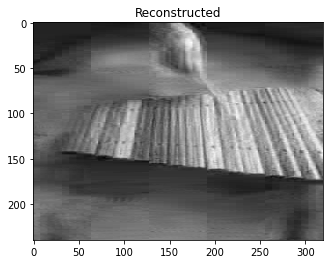

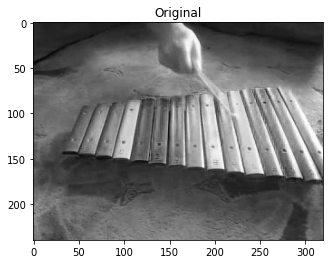

In [63]:
#PASTE
def Pasteimage(pileofpatches):
  return np.reshape(pileofpatches, (240,320))
 
reconstructed_frame = Pasteimage(reconstructed_patches)
plt.title("Reconstructed")
plt.imshow(reconstructed_frame, cmap ='gray')
plt.show()
plt.title("Original")
plt.imshow(frame80, cmap ='gray')

# Puts a pile of patches together into a frame
# Input a pile of patches, estimated dimensions: 8x8xmany
# Output a black and white frame

You will also need this to finish the report.

In [66]:
#PSNR
def CalculatePSNR(im1, im2): 
  PSNR = 10 * np.log10(255**2/(np.mean(im1)-np.mean(im2))**2)
  return PSNR

PSNR = CalculatePSNR(test, reconstructed_frame)
print("PSNR: " + str(PSNR) + " dB")

# This function calculates the PSNR between two colour images, im1, im2
# You can use numpy.shape to check if two images are of the same size
# otherwise you can for example use numpy.resize to make them match
# PSNR should be in dB

#Put your code from the PSNR block from previous assignments here.

PSNR: 48.028489830105826 dB


#Report

In your report, you need to 
1. Print the photo of Y frame 80 and its
reconstructed version. Show them side by side and give them clear titles. 
2. Give PSNR of the reconstructed Y frame 80.
3. Your entire notebook, with relevant images and string plotted and printed.
4. Submit your report as a single pdf, combined from your report text and your notebook.

Upload your report to “Assignments/Project1”.

Deadline is 18 May 2021 23:59